In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import copy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Dataset Import

In [2]:
base_path = r'C:\Users\RACYM\Desktop\fac\M2_PFE\datasets\CIC-DDoS2019\\'

cic_ddos2019 = {
    'DNS-test': pd.read_parquet(base_path + 'DNS-testing.parquet', engine='fastparquet'),
    'LDAP-test': pd.read_parquet(base_path + 'LDAP-testing.parquet', engine='fastparquet'),
    'LDAP-train': pd.read_parquet(base_path + 'LDAP-training.parquet', engine='fastparquet'),
    'MSSQL-test': pd.read_parquet(base_path + 'MSSQL-testing.parquet', engine='fastparquet'),
    'MSSQL-train': pd.read_parquet(base_path + 'MSSQL-training.parquet', engine='fastparquet'),
    'NetBIOS-test': pd.read_parquet(base_path + 'NetBIOS-testing.parquet', engine='fastparquet'),
    'NetBIOS-train': pd.read_parquet(base_path + 'NetBIOS-training.parquet', engine='fastparquet'),
    'NTP-test': pd.read_parquet(base_path + 'NTP-testing.parquet', engine='fastparquet'),
    'Portmap-train': pd.read_parquet(base_path + 'Portmap-training.parquet', engine='fastparquet'),
    'SNMP-test': pd.read_parquet(base_path + 'SNMP-testing.parquet', engine='fastparquet'),
    'Syn-test': pd.read_parquet(base_path + 'Syn-testing.parquet', engine='fastparquet'),
    'Syn-train': pd.read_parquet(base_path + 'Syn-training.parquet', engine='fastparquet'),
    'TFTP-test': pd.read_parquet(base_path + 'TFTP-testing.parquet', engine='fastparquet'),
    'UDPLag-test': pd.read_parquet(base_path + 'UDPLag-testing.parquet', engine='fastparquet'),
    'UDPLag-train': pd.read_parquet(base_path + 'UDPLag-training.parquet', engine='fastparquet'),
    'UDP-test': pd.read_parquet(base_path + 'UDP-testing.parquet', engine='fastparquet'),
    'UDP-train': pd.read_parquet(base_path + 'UDP-training.parquet', engine='fastparquet'),
}

# merging between train sets and test sets for each attack type
cic_ddos2019_merged = {
    'DNS': cic_ddos2019['DNS-test'],
    'LDAP': pd.concat([cic_ddos2019['LDAP-train'], cic_ddos2019['LDAP-test']], ignore_index=True),
    'MSSQL': pd.concat([cic_ddos2019['MSSQL-train'], cic_ddos2019['MSSQL-test']], ignore_index=True),
    'NetBIOS': pd.concat([cic_ddos2019['NetBIOS-train'], cic_ddos2019['NetBIOS-test']], ignore_index=True),    
    'NTP': cic_ddos2019['NTP-test'],
    'Portmap': cic_ddos2019['Portmap-train'],
    'SNMP': cic_ddos2019['SNMP-test'],
    'Syn': pd.concat([cic_ddos2019['Syn-train'], cic_ddos2019['Syn-test']], ignore_index=True),
    'TFTP': cic_ddos2019['TFTP-test'],
    'UDPLag': pd.concat([cic_ddos2019['UDPLag-train'], cic_ddos2019['UDPLag-test']], ignore_index=True),
    'UDP': pd.concat([cic_ddos2019['UDP-train'], cic_ddos2019['UDP-test']], ignore_index=True),
}

# merging all attack types 
cic_ddos2019_all = pd.concat(cic_ddos2019_merged.values(), ignore_index=True)

In [3]:
# maxSamples = 5000
# balancedParts = []
# for label, group in cic_ddos2019_all.groupby('Label'):
#     if maxSamples <= len(group):
#         sampled_DF = group.sample(n=maxSamples)
#     else:
#         sampled_DF = group
#     balancedParts.append(sampled_DF)
# cic_ddos2019_all = pd.concat(balancedParts, ignore_index=True)

# print(cic_ddos2019_all.shape)

# Data Preprocessing

In [4]:
# dropping constant features
cic_ddos2019_all.drop(['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'PSH Flag Count',
 'ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate'], axis=1, inplace=True)

# dropping columns highly correlated with other columns
cic_ddos2019_all.drop(['Bwd Packets Length Total',
                                'Fwd Packet Length Mean',
                                'Bwd Packet Length Std', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
                                'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Std',
                                'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
                                'Subflow Bwd Bytes', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min'], axis=1, inplace=True)

# Outlier treatement
labels = cic_ddos2019_all['Label']
cic_ddos2019_all = (cic_ddos2019_all.iloc[:,:-1] - cic_ddos2019_all.iloc[:,:-1].mean()) / cic_ddos2019_all.iloc[:,:-1].std()
cic_ddos2019_all['Protocol'], _ = pd.factorize(cic_ddos2019_all['Protocol'])
cic_ddos2019_all['Flow Duration'] = np.log1p(cic_ddos2019_all['Flow Duration']).clip(upper=0)
cic_ddos2019_all['Total Fwd Packets'] = np.log1p(cic_ddos2019_all['Total Fwd Packets']).clip(upper=0.2)
cic_ddos2019_all['Total Backward Packets'] = np.log1p(cic_ddos2019_all['Total Backward Packets']).clip(upper=0.2)
cic_ddos2019_all['Fwd Packets Length Total'] = np.log1p(cic_ddos2019_all['Fwd Packets Length Total']).clip(upper=0.5)
cic_ddos2019_all['Fwd Packet Length Max'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Max'].clip(lower=0)).clip(upper=1.25)

cic_ddos2019_all['Fwd Packet Length Min'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Min'].clip(lower=0)).clip(upper=2)
cic_ddos2019_all['Fwd Packet Length Std'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Std']).clip(upper=-0.3)
cic_ddos2019_all['Bwd Packet Length Max'] = np.log1p(cic_ddos2019_all['Bwd Packet Length Max']).clip(upper=-0.16)
cic_ddos2019_all['Bwd Packet Length Min'] = cic_ddos2019_all['Bwd Packet Length Min'].clip(lower=0, upper=10)
cic_ddos2019_all['Bwd Packet Length Mean'] = cic_ddos2019_all['Bwd Packet Length Mean'].clip(lower=0, upper=15)
cic_ddos2019_all['Flow Bytes/s'] = np.log1p(cic_ddos2019_all['Flow Bytes/s']).clip(upper=-0.1)

cic_ddos2019_all['Flow Packets/s'] = np.log1p(cic_ddos2019_all['Flow Packets/s']).clip(upper=0.2)
cic_ddos2019_all['Flow IAT Mean'] = np.log1p(cic_ddos2019_all['Flow IAT Mean']).clip(upper=2)
cic_ddos2019_all['Flow IAT Max'] = np.log1p(cic_ddos2019_all['Flow IAT Max']).clip(upper=1)
cic_ddos2019_all['Flow IAT Min'] = np.log1p(cic_ddos2019_all['Flow IAT Min']).clip(upper=1)
cic_ddos2019_all['Bwd IAT Total'] = np.log1p(cic_ddos2019_all['Bwd IAT Total']).clip(upper=-0.15)
cic_ddos2019_all['Bwd IAT Mean'] = np.log1p(cic_ddos2019_all['Bwd IAT Mean']).clip(upper=-0.2)

cic_ddos2019_all['Bwd IAT Min'] = np.log1p(cic_ddos2019_all['Bwd IAT Min']).clip(upper=1)
cic_ddos2019_all['Fwd PSH Flags'], _ = pd.factorize(cic_ddos2019_all['Fwd PSH Flags'])
cic_ddos2019_all['Fwd Header Length'] = cic_ddos2019_all['Fwd Header Length'].clip(lower=-20)
cic_ddos2019_all['Bwd Header Length'] = cic_ddos2019_all['Bwd Header Length'].clip(lower=-100)
cic_ddos2019_all['Bwd Packets/s'] = np.log1p(cic_ddos2019_all['Bwd Packets/s']).clip(upper=1)
cic_ddos2019_all['Packet Length Max'] = cic_ddos2019_all['Packet Length Max'].clip(upper=6)

cic_ddos2019_all['Packet Length Variance'] = np.log1p(cic_ddos2019_all['Packet Length Variance']).clip(lower=0, upper=2)
cic_ddos2019_all['SYN Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['SYN Flag Count']))
cic_ddos2019_all['ACK Flag Count'], _ = pd.factorize(cic_ddos2019_all['ACK Flag Count'])
cic_ddos2019_all['URG Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['URG Flag Count']))
cic_ddos2019_all['CWE Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['CWE Flag Count']))
cic_ddos2019_all['Down/Up Ratio'] = cic_ddos2019_all['Down/Up Ratio'].clip(lower=0, upper=4)

cic_ddos2019_all['Init Fwd Win Bytes'] = np.log1p(cic_ddos2019_all['Init Fwd Win Bytes']).clip(upper=-0.2)
cic_ddos2019_all['Init Bwd Win Bytes'] = np.log1p(cic_ddos2019_all['Init Bwd Win Bytes']).clip(upper=1)
cic_ddos2019_all['Fwd Act Data Packets'] = np.log1p(cic_ddos2019_all['Fwd Act Data Packets']).clip(upper=1)
cic_ddos2019_all['Fwd Seg Size Min'] = cic_ddos2019_all['Fwd Seg Size Min']
cic_ddos2019_all['Active Mean'] = np.log1p(cic_ddos2019_all['Active Mean']).clip(upper=-0.109)
cic_ddos2019_all['Active Std'] = np.log1p(cic_ddos2019_all['Active Std']).clip(upper=-0.115)

cic_ddos2019_all['Active Max'] = np.log1p(cic_ddos2019_all['Active Max']).clip(upper=0)
cic_ddos2019_all['Idle Std'] = np.log1p(cic_ddos2019_all['Idle Std']).clip(upper=-0.115)

cic_ddos2019_all['Label'] = labels

# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cic_ddos2019_all_c = scaler.fit_transform(cic_ddos2019_all.iloc[:,:-1].to_numpy())
cic_ddos2019_all = pd.DataFrame(cic_ddos2019_all_c, columns=cic_ddos2019_all.columns[:-1])
cic_ddos2019_all['Label'] = labels


In [5]:
cic_ddos2019_all['Label'].unique().tolist()

['DrDoS_DNS',
 'Benign',
 'NetBIOS',
 'LDAP',
 'DrDoS_LDAP',
 'MSSQL',
 'DrDoS_MSSQL',
 'DrDoS_NetBIOS',
 'DrDoS_NTP',
 'Portmap',
 'DrDoS_SNMP',
 'Syn',
 'TFTP',
 'UDP',
 'UDPLag',
 'UDP-lag',
 'WebDDoS',
 'DrDoS_UDP']

# Training Part

In [6]:
import DDoS_cic_v2
from importlib import reload
reload(DDoS_cic_v2)

from DDoS_cic_v2 import AIRS

## Model A : DDoS / No DDoS

In [7]:
map_A = {'Portmap' : 0,
'DrDoS_NTP' : 0,
'NetBIOS' : 0,
'DrDoS_LDAP' : 0,
'UDP' : 0,
'DrDoS_SNMP' : 0,
'Benign' : 1,
'DrDoS_NetBIOS' : 0,
'DrDoS_MSSQL' : 0,
'MSSQL' : 0,
'WebDDoS' : 0,
'Syn' : 0,
'LDAP' : 0,
'TFTP' : 0,
'UDP-lag' : 0,
'UDPLag' : 0,
'DrDoS_UDP' : 0,
'DrDoS_DNS' : 0}


dataset_A = pd.concat([cic_ddos2019_all[cic_ddos2019_all['Label'] != 'Benign'].sample(n=8000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=8000)],
                       ignore_index=True)
dataset_A['Label'] = dataset_A['Label'].map(map_A)
dataset_A['Label'].value_counts()


# oversampling the minority values with SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1])
dataset_A = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_A['Label'] = classes_resampled

# spliting train_test
X_train, X_test, Y_train, Y_test = train_test_split(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1], test_size=0.2, random_state=10, stratify=dataset_A.iloc[:,-1])
trainset_A = pd.DataFrame(X_train)
trainset_A['Label'] = Y_train
testset_A = pd.DataFrame(X_test)
testset_A['Label'] = Y_test
print(trainset_A.Label.value_counts())
print(testset_A.Label.value_counts())

trainset_A = trainset_A.to_numpy()
testset_A = testset_A.to_numpy()

Model_A = AIRS(train_set=trainset_A,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=100,
                  CLASS_NUMBER=2,
                  MC_INIT_RATE=0.06,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=10,
                  MAX_ITER=100,
                  AFFINITY_THRESHOLD_SCALAR=1.8,
                  KNN_K= 5)

Label
1    6400
0    6400
Name: count, dtype: int64
Label
1    1600
0    1600
Name: count, dtype: int64


In [8]:
# Model_A.calculate_affinity_threshold()
Model_A.AFFINITY_THRESHOLD = 0.5674127071785825

In [9]:
Model_A.train()

Training Started

progression : 640 / 12800   -   5.0%
progression : 1280 / 12800   -   10.0%
progression : 1920 / 12800   -   15.0%
progression : 2560 / 12800   -   20.0%
progression : 3200 / 12800   -   25.0%
progression : 3840 / 12800   -   30.0%
progression : 4480 / 12800   -   35.0%
progression : 5120 / 12800   -   40.0%
progression : 5760 / 12800   -   45.0%
progression : 6400 / 12800   -   50.0%
progression : 7040 / 12800   -   55.00000000000001%
progression : 7680 / 12800   -   60.0%
progression : 8320 / 12800   -   65.0%
progression : 8960 / 12800   -   70.0%
progression : 9600 / 12800   -   75.0%
progression : 10240 / 12800   -   80.0%
progression : 10880 / 12800   -   85.0%
progression : 11520 / 12800   -   90.0%
progression : 12160 / 12800   -   95.0%
progression : 12800 / 12800   -   100.0%
Training complete



In [10]:
Model_A.Eval(testset_A)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 99.03125 %


In [11]:
Model_A.showModelInfo()

Model Trained in  1 minutes 48 seconds

Dataset lenght : 16000   =  12800 (trainset)  +  3200 (testset)

size of MC POOL : 768
MC class 0 : 380
MC class 1 : 388


In [12]:
Model_A.getAccuracy()

0.9903125

## Model B : General classes

In [13]:
map_B = {'Portmap' : 0,
'NetBIOS' : 1,
'DrDoS_NetBIOS' : 1,
'DrDoS_NTP' : 11,
'DrDoS_LDAP' : 3,
'LDAP' : 3,
'DrDoS_SNMP' : 4,
'UDP' : 5,
'UDP-lag' : 5,
'UDPLag' : 5,
'DrDoS_UDP' : 5,
'Benign' : 6,
'DrDoS_MSSQL' : 7,
'MSSQL' : 7,
'WebDDoS' : 8,
'Syn' : 9,
'TFTP' : 10,
'DrDoS_DNS' : 2}


dataset_B = pd.concat([cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Portmap'].sample(n=685),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_DNS'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'NetBIOS'].sample(n=644),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NetBIOS'].sample(n=598),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_LDAP'].sample(n=1100),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'LDAP'].sample(n=1900),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_SNMP'].sample(n=2717),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP'].sample(n=2000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP-lag'].sample(n=400),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDPLag'].sample(n=50),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_UDP'].sample(n=550),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_MSSQL'].sample(n=1500),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'MSSQL'].sample(n=1500),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'WebDDoS'].sample(n=51),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Syn'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'TFTP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NTP'].sample(n=3000),
                       ],
                       ignore_index=True)
dataset_B['Label'] = dataset_B['Label'].map(map_B)
print(dataset_B['Label'].value_counts())


# oversampling the minority values with SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1])
dataset_B = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_B['Label'] = classes_resampled


print(dataset_B['Label'].value_counts())


# spliting train_test
X_train, X_test, Y_train, Y_test = train_test_split(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1], test_size=0.2, random_state=10, stratify=dataset_B.iloc[:,-1])
trainset_B = pd.DataFrame(X_train)
trainset_B['Label'] = Y_train
testset_B = pd.DataFrame(X_test)
testset_B['Label'] = Y_test
print(trainset_B.Label.value_counts())
print(testset_B.Label.value_counts())

trainset_B = trainset_B.to_numpy()
testset_B = testset_B.to_numpy()

Model_B = AIRS(train_set=trainset_B,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=100,
                  CLASS_NUMBER=12,
                  MC_INIT_RATE=0.06,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=10,
                  MAX_ITER=100,
                  AFFINITY_THRESHOLD_SCALAR=0.5,
                  KNN_K= 5)

Label
6     3000
2     3000
5     3000
3     3000
11    3000
10    3000
7     3000
9     3000
4     2717
1     1242
0      685
8       51
Name: count, dtype: int64
Label
6     3000
0     3000
2     3000
1     3000
3     3000
4     3000
5     3000
7     3000
8     3000
9     3000
10    3000
11    3000
Name: count, dtype: int64
Label
8     2400
1     2400
10    2400
2     2400
7     2400
4     2400
11    2400
6     2400
3     2400
5     2400
0     2400
9     2400
Name: count, dtype: int64
Label
1     600
4     600
6     600
0     600
9     600
2     600
10    600
8     600
5     600
11    600
7     600
3     600
Name: count, dtype: int64


In [14]:
Model_B.calculate_affinity_threshold()
# Model_B.AFFINITY_THRESHOLD = 0.5654127748111915

calculating the affinity threshold...
progresion : 10 %
progresion : 20 %
progresion : 30 %
progresion : 40 %
progresion : 50 %
progresion : 60 %
progresion : 70 %
progresion : 80 %
progresion : 90 %
progresion : 100 %
Affinity threshold calculated : 0.39486166082368224



In [15]:
Model_B.train()

Training Started

progression : 1440 / 28800   -   5.0%
progression : 2880 / 28800   -   10.0%
progression : 4320 / 28800   -   15.0%
progression : 5760 / 28800   -   20.0%
progression : 7200 / 28800   -   25.0%
progression : 8640 / 28800   -   30.0%
progression : 10080 / 28800   -   35.0%
progression : 11520 / 28800   -   40.0%
progression : 12960 / 28800   -   45.0%
progression : 14400 / 28800   -   50.0%
progression : 15840 / 28800   -   55.00000000000001%
progression : 17280 / 28800   -   60.0%
progression : 18720 / 28800   -   65.0%
progression : 20160 / 28800   -   70.0%
progression : 21600 / 28800   -   75.0%
progression : 23040 / 28800   -   80.0%
progression : 24480 / 28800   -   85.0%
progression : 25920 / 28800   -   90.0%
progression : 27360 / 28800   -   95.0%
progression : 28800 / 28800   -   100.0%
Training complete



In [16]:
Model_B.Eval(testset_B)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 75.88888888888889 %


In [17]:
Model_B.showModelInfo()

Model Trained in  2 minutes 56 seconds

Dataset lenght : 36000   =  28800 (trainset)  +  7200 (testset)

size of MC POOL : 5961
MC class 0 : 480
MC class 1 : 187
MC class 2 : 248
MC class 3 : 172
MC class 4 : 165
MC class 5 : 384
MC class 6 : 1493
MC class 7 : 136
MC class 8 : 756
MC class 9 : 1252
MC class 10 : 175
MC class 11 : 513


## Model C : ALL Classes

In [18]:
map_C = {'Portmap' : 0,
'NetBIOS' : 1,
'DrDoS_NetBIOS' : 2,
'DrDoS_DNS' : 3,
'DrDoS_LDAP' : 4,
'LDAP' : 5,
'DrDoS_SNMP' : 6,
'UDP' : 7,
'DrDoS_UDP' : 8,
'UDP-lag' : 9,
'UDPLag' : 9,
'Benign' : 10,
'DrDoS_MSSQL' : 11,
'MSSQL' : 12,
'WebDDoS' : 13,
'Syn' : 14,
'TFTP' : 15,
'DrDoS_NTP' : 16,
}


dataset_C = pd.concat([
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Portmap'].sample(n=685),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_DNS'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'NetBIOS'].sample(n=644),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NetBIOS'].sample(n=598),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_LDAP'].sample(n=1440),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'LDAP'].sample(n=1906),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_SNMP'].sample(n=2717),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP-lag'].sample(n=2945),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDPLag'].sample(n=55),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_UDP'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_MSSQL'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'MSSQL'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'WebDDoS'].sample(n=51),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Syn'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'TFTP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NTP'].sample(n=3000),
                       ],
                       ignore_index=True)
dataset_C['Label'] = dataset_C['Label'].map(map_C)
print(dataset_C['Label'].value_counts())


# oversampling the minority values with SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1])
dataset_C = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_C['Label'] = classes_resampled


print(dataset_B['Label'].value_counts())


# spliting train_test
X_train, X_test, Y_train, Y_test = train_test_split(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1], test_size=0.2, random_state=10, stratify=dataset_C.iloc[:,-1])
trainset_C = pd.DataFrame(X_train)
trainset_C['Label'] = Y_train
testset_C = pd.DataFrame(X_test)
testset_C['Label'] = Y_test
print(trainset_C.Label.value_counts())
print(testset_C.Label.value_counts())

trainset_C = trainset_C.to_numpy()
testset_C = testset_C.to_numpy()

Model_C = AIRS(train_set=trainset_C,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=100,
                  CLASS_NUMBER=17,
                  MC_INIT_RATE=0.06,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=10,
                  MAX_ITER=100,
                  AFFINITY_THRESHOLD_SCALAR=1.8,
                  KNN_K= 3)

Label
3     3000
16    3000
9     3000
7     3000
14    3000
12    3000
11    3000
10    3000
8     3000
15    3000
6     2717
5     1906
4     1440
0      685
1      644
2      598
13      51
Name: count, dtype: int64
Label
6     3000
0     3000
2     3000
1     3000
3     3000
4     3000
5     3000
7     3000
8     3000
9     3000
10    3000
11    3000
Name: count, dtype: int64
Label
3     2400
4     2400
0     2400
16    2400
8     2400
15    2400
11    2400
6     2400
5     2400
10    2400
12    2400
13    2400
9     2400
2     2400
1     2400
7     2400
14    2400
Name: count, dtype: int64
Label
5     600
0     600
13    600
6     600
2     600
9     600
8     600
1     600
16    600
11    600
15    600
10    600
12    600
3     600
4     600
7     600
14    600
Name: count, dtype: int64


In [19]:
# Model_C.calculate_affinity_threshold()
Model_C.AFFINITY_THRESHOLD = 0.4088285921392604

In [20]:
Model_C.train()

Training Started

progression : 2040 / 40800   -   5.0%
progression : 4080 / 40800   -   10.0%
progression : 6120 / 40800   -   15.0%
progression : 8160 / 40800   -   20.0%
progression : 10200 / 40800   -   25.0%
progression : 12240 / 40800   -   30.0%
progression : 14280 / 40800   -   35.0%
progression : 16320 / 40800   -   40.0%
progression : 18360 / 40800   -   45.0%
progression : 20400 / 40800   -   50.0%
progression : 22440 / 40800   -   55.00000000000001%
progression : 24480 / 40800   -   60.0%
progression : 26520 / 40800   -   65.0%
progression : 28560 / 40800   -   70.0%
progression : 30600 / 40800   -   75.0%
progression : 32640 / 40800   -   80.0%
progression : 34680 / 40800   -   85.0%
progression : 36720 / 40800   -   90.0%
progression : 38760 / 40800   -   95.0%
progression : 40800 / 40800   -   100.0%
Training complete



In [21]:
Model_C.Eval(testset_C)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 59.0 %


In [22]:
Model_C.showModelInfo()

Model Trained in  4 minutes 29 seconds

Dataset lenght : 51000   =  40800 (trainset)  +  10200 (testset)

size of MC POOL : 7488
MC class 0 : 450
MC class 1 : 209
MC class 2 : 191
MC class 3 : 292
MC class 4 : 148
MC class 5 : 150
MC class 6 : 163
MC class 7 : 196
MC class 8 : 210
MC class 9 : 709
MC class 10 : 1554
MC class 11 : 136
MC class 12 : 180
MC class 13 : 743
MC class 14 : 1332
MC class 15 : 149
MC class 16 : 676


# Comparaison

In [23]:
Model_A.showModelInfo()
Model_B.showModelInfo()
Model_C.showModelInfo()

Model Trained in  1 minutes 48 seconds

Dataset lenght : 16000   =  12800 (trainset)  +  3200 (testset)

size of MC POOL : 768
MC class 0 : 380
MC class 1 : 388
Model Trained in  2 minutes 56 seconds

Dataset lenght : 36000   =  28800 (trainset)  +  7200 (testset)

size of MC POOL : 5961
MC class 0 : 480
MC class 1 : 187
MC class 2 : 248
MC class 3 : 172
MC class 4 : 165
MC class 5 : 384
MC class 6 : 1493
MC class 7 : 136
MC class 8 : 756
MC class 9 : 1252
MC class 10 : 175
MC class 11 : 513
Model Trained in  4 minutes 29 seconds

Dataset lenght : 51000   =  40800 (trainset)  +  10200 (testset)

size of MC POOL : 7488
MC class 0 : 450
MC class 1 : 209
MC class 2 : 191
MC class 3 : 292
MC class 4 : 148
MC class 5 : 150
MC class 6 : 163
MC class 7 : 196
MC class 8 : 210
MC class 9 : 709
MC class 10 : 1554
MC class 11 : 136
MC class 12 : 180
MC class 13 : 743
MC class 14 : 1332
MC class 15 : 149
MC class 16 : 676


In [24]:
current_accuracies = [Model_A.getAccuracy(), Model_B.getAccuracy(), Model_C.getAccuracy()]
print(current_accuracies)

[0.9903125, 0.7588888888888888, 0.59]


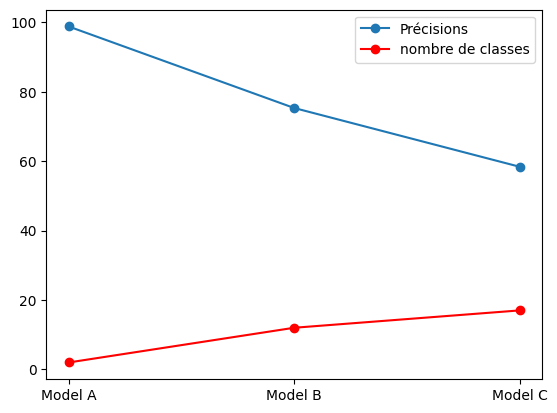

In [25]:
models = ['Model A', 'Model B', 'Model C']
accuracies = [98.8, 75.319, 58.392]
classNumbers = [Model_A.CLASS_NUMBER, Model_B.CLASS_NUMBER, Model_C.CLASS_NUMBER]

fig, ax = plt.subplots()
ax.plot(models, accuracies, 'o-', label='Précisions')
ax.plot(models, classNumbers, 'o-r', label='nombre de classes')
ax.legend()

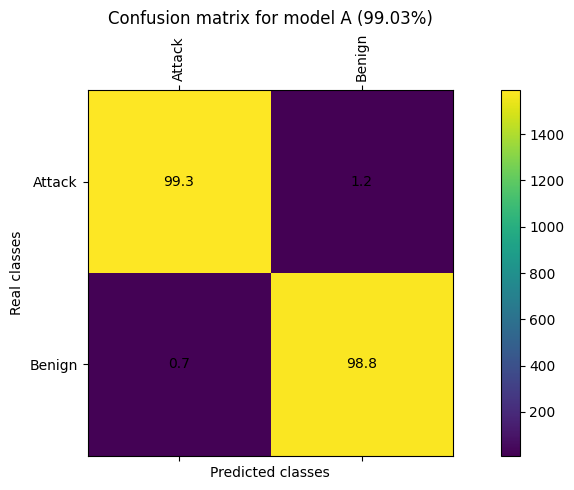

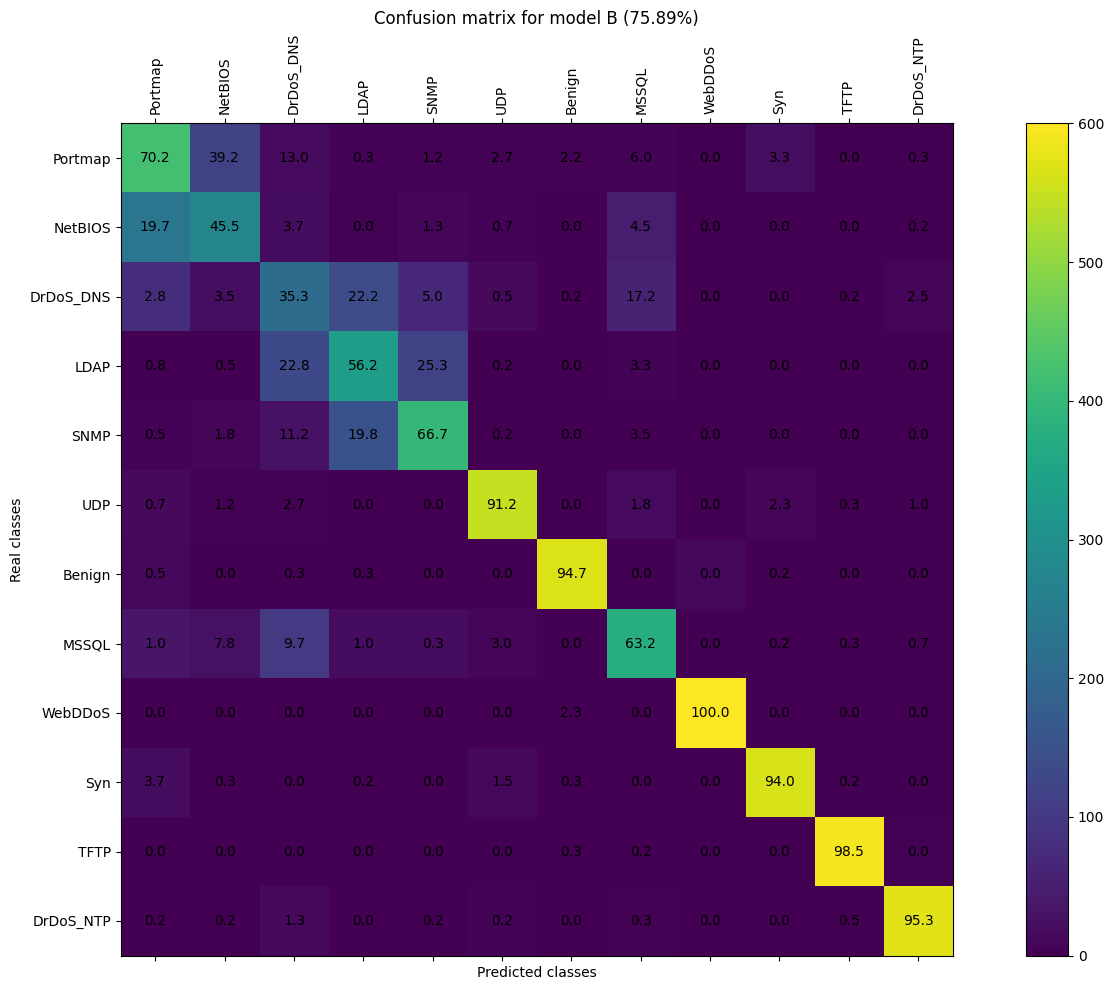

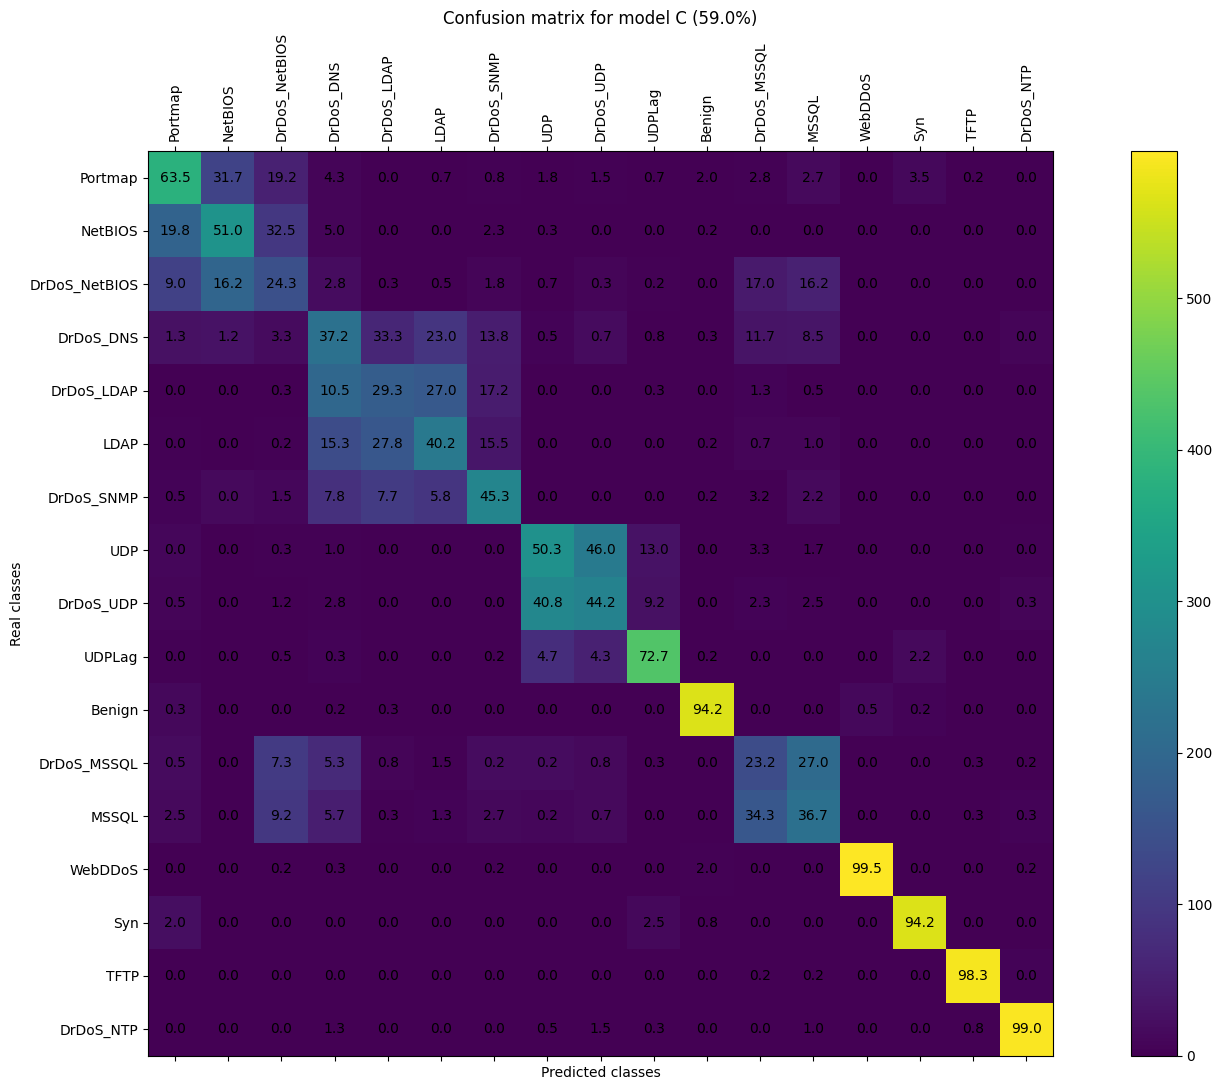

In [35]:
Model_A.displayConfusionMatrix(class_names=['Attack', 'Benign'], figsize=(10,5), max=1600, title='Confusion matrix for model A ({}%)'.format(round(Model_A.getAccuracy()*100, 2)))
Model_B.displayConfusionMatrix(class_names=['Portmap', 'NetBIOS', 'DrDoS_DNS', 'LDAP', 'SNMP', 'UDP', 'Benign', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP'], figsize=(15,10), max=600, title='Confusion matrix for model B ({}%)'.format(round(Model_B.getAccuracy()*100, 2)))
Model_C.displayConfusionMatrix(class_names=['Portmap', 'NetBIOS', 'DrDoS_NetBIOS', 'DrDoS_DNS', 'DrDoS_LDAP', 'LDAP', 'DrDoS_SNMP', 'UDP', 'DrDoS_UDP', 'UDPLag', 'Benign', 'DrDoS_MSSQL', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP'], figsize=(16,11), max=600, title='Confusion matrix for model C ({}%)'.format(round(Model_C.getAccuracy()*100, 2)))

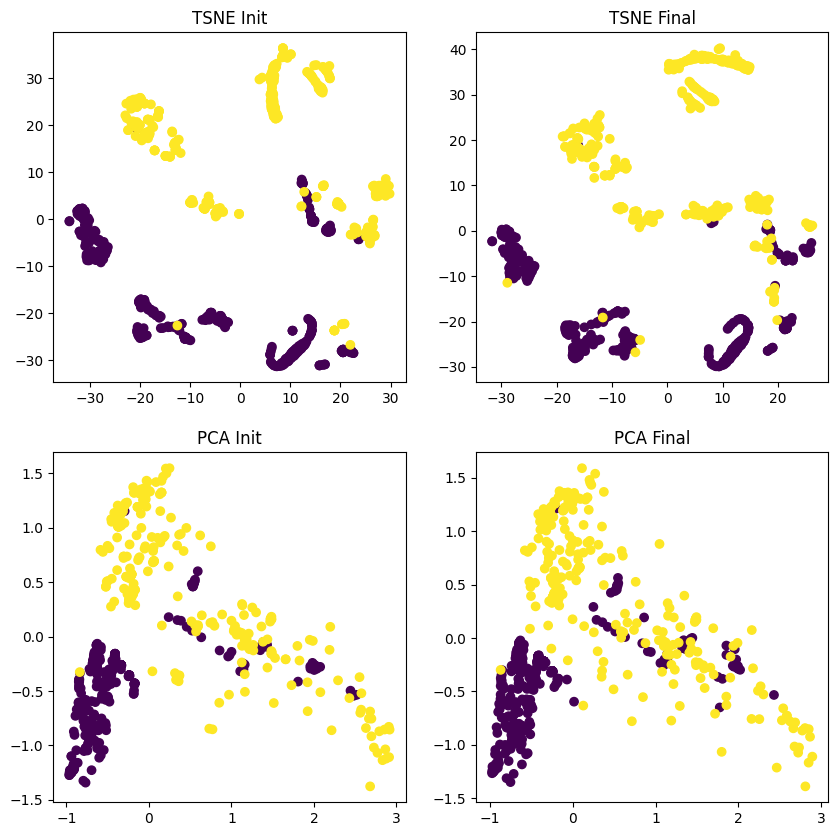

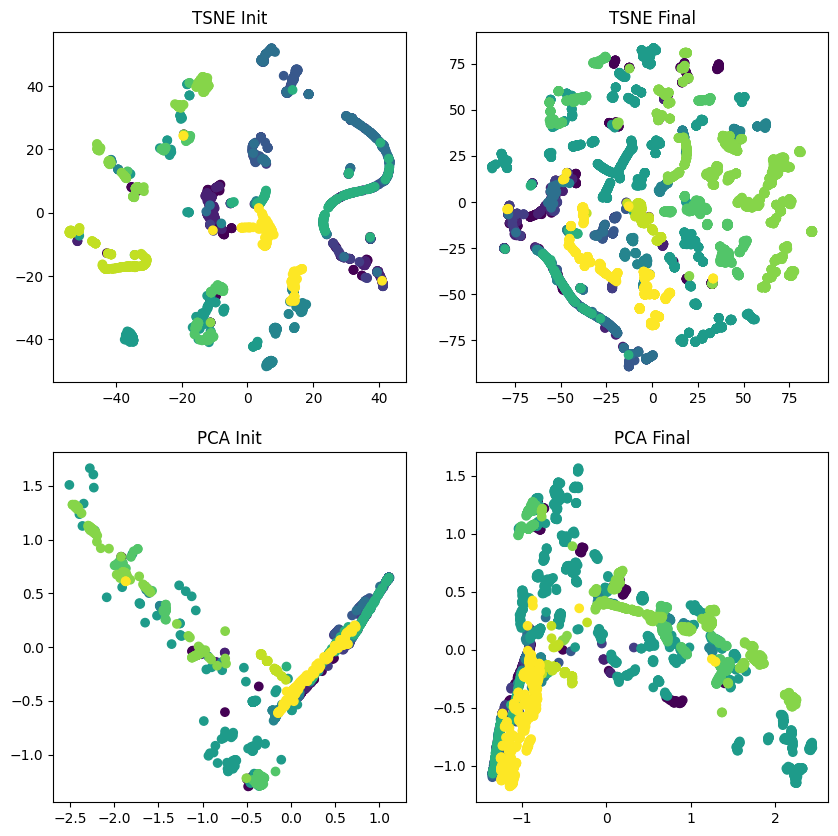

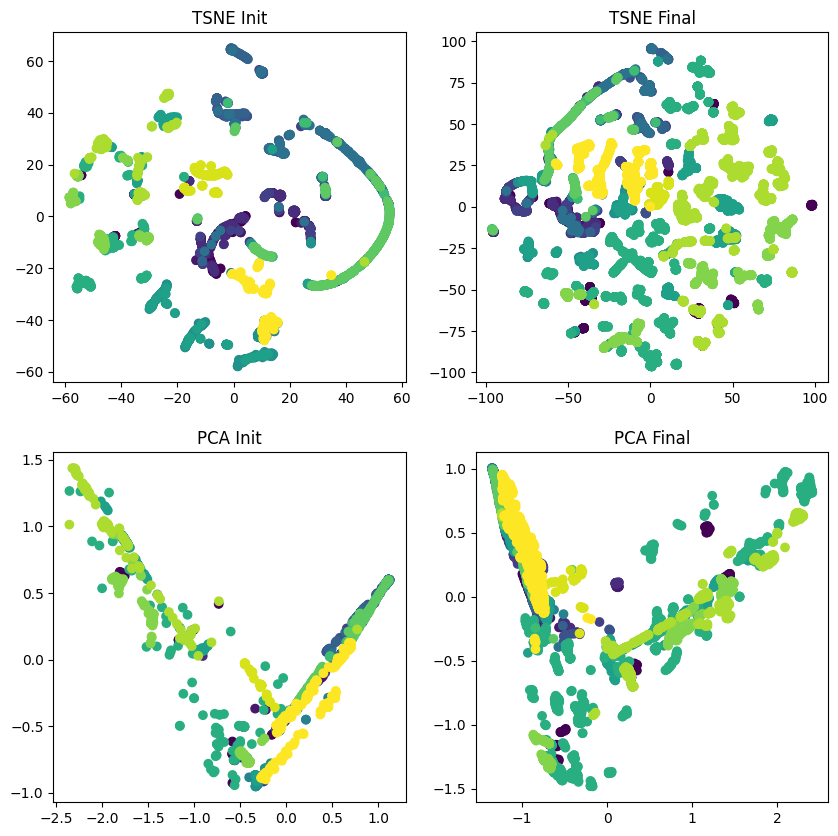

In [27]:
Model_A.displayEvolution()
Model_B.displayEvolution()
Model_C.displayEvolution()

# Artificial Neural Network

## Hybdrid model

In [28]:
# getting the new dataset from MC pool + train test split
mcA_x, mcA_y = Model_A.getMcPOOLasDataset()
mcB_x, mcB_y = Model_B.getMcPOOLasDataset()
mcC_x, mcC_y = Model_C.getMcPOOLasDataset()

x_train_A, x_test_A, y_train_A, y_test_A = train_test_split(mcA_x, mcA_y, test_size=0.2, random_state=10)
x_train_B, x_test_B, y_train_B, y_test_B = train_test_split(mcB_x, mcB_y, test_size=0.2, random_state=10)
x_train_C, x_test_C, y_train_C, y_test_C = train_test_split(mcC_x, mcC_y, test_size=0.2, random_state=10)

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

MLP_classifier = MLPClassifier(hidden_layer_sizes=(250,), activation='relu', solver='adam', max_iter=2000, random_state=10)

MLP_classifier.fit(x_train_A, y_train_A)
y_pred_A = MLP_classifier.predict(x_test_A)
MLP_classifier.fit(x_train_B, y_train_B)
y_pred_B = MLP_classifier.predict(x_test_B)
MLP_classifier.fit(x_train_C, y_train_C)
y_pred_C = MLP_classifier.predict(x_test_C)

In [30]:
print(confusion_matrix(y_test_A, y_pred_A))
print(classification_report(y_test_A, y_pred_A))
print(confusion_matrix(y_test_B, y_pred_B))
print(classification_report(y_test_B, y_pred_B))
print(confusion_matrix(y_test_C, y_pred_C))
print(classification_report(y_test_C, y_pred_C))

report_A = classification_report(y_test_A, y_pred_A, output_dict=True)
report_B = classification_report(y_test_B, y_pred_B, output_dict=True)
report_C = classification_report(y_test_C, y_pred_C, output_dict=True)

[[73  0]
 [ 3 78]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        73
         1.0       1.00      0.96      0.98        81

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154

[[ 82  15   0   0   0   0   0   3   0   5   0   0]
 [ 14   9   0   2   1   0   0   6   0   1   0   0]
 [  4   4  19   9   7   2   0   9   0   0   0   4]
 [  0   0   0  25   6   0   0   2   0   0   0   0]
 [  3   1   0   9  23   0   0   0   0   0   0   0]
 [  0   0   0   0   0  74   0   4   0   0   0   0]
 [  0   0   0   0   0   0 312   0   0   0   0   0]
 [  0   0   1   0   1   1   0  24   0   0   0   0]
 [  0   0   0   0   0   0   0   0 163   0   0   0]
 [ 11   0   0   0   0   1   0   0   0 220   0   0]
 [  0   0   0   0   0   0   0   0   0   0  25   0]
 [  0   0   0   0   0   0   0   0   0   0   0  91]]
              precision    recall  f1-sco

In [31]:
print(report_A['accuracy'])
print(report_B['accuracy'])
print(report_C['accuracy'])

0.9805194805194806
0.8943839061190276
0.8190921228304406


## MLP Alone

In [33]:
x_train_A_o, x_test_A_o, y_train_A_o, y_test_A_o = train_test_split(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1], test_size=0.2, random_state=10)
x_train_B_o, x_test_B_o, y_train_B_o, y_test_B_o = train_test_split(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1], test_size=0.2, random_state=10)
x_train_C_o, x_test_C_o, y_train_C_o, y_test_C_o = train_test_split(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1], test_size=0.2, random_state=10)

MLP_classifier.fit(x_train_A_o, y_train_A_o)
y_pred_A_o = MLP_classifier.predict(x_test_A_o)
MLP_classifier.fit(x_train_B_o, y_train_B_o)
y_pred_B_o = MLP_classifier.predict(x_test_B_o)
MLP_classifier.fit(x_train_C_o, y_train_C_o)
y_pred_C_o = MLP_classifier.predict(x_test_C_o)

report_A_o = classification_report(y_test_A_o, y_pred_A_o, output_dict=True)
report_B_o = classification_report(y_test_B_o, y_pred_B_o, output_dict=True)
report_C_o = classification_report(y_test_C_o, y_pred_C_o, output_dict=True)

# Comparaison AIRS vs Hybrid (AIRS + MLP)

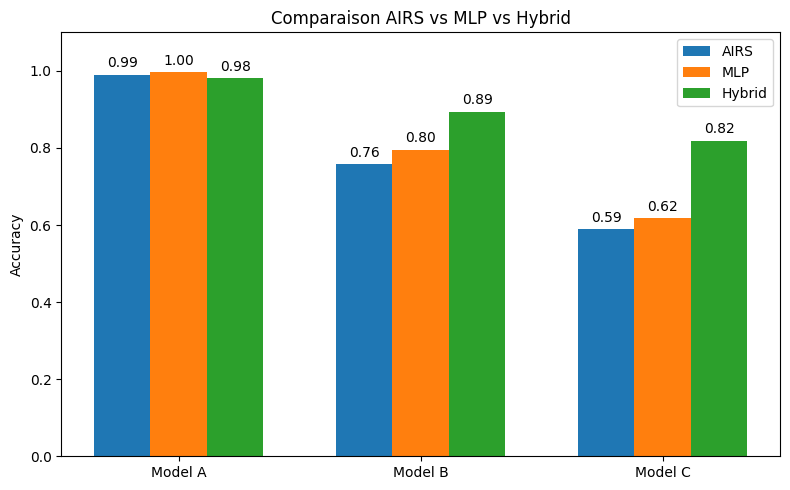

In [34]:
old_accuracies = [Model_A.getAccuracy(), Model_B.getAccuracy(), Model_C.getAccuracy()]
new_accuracies = [report_A['accuracy'], report_B['accuracy'], report_C['accuracy']]
original_accuracies = [report_A_o['accuracy'], report_B_o['accuracy'], report_C_o['accuracy']]

x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/3*2, old_accuracies, width/1.5, label='AIRS')
rects2 = ax.bar(x + width/2*0, original_accuracies, width/1.5, label='MLP')
rects3 = ax.bar(x + width/3*2, new_accuracies, width/1.5, label='Hybrid')

# Add labels
ax.set_ylabel('Accuracy')
ax.set_title('Comparaison AIRS vs MLP vs Hybrid')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()

# Add accuracy values on top of bars
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()
